In [1]:
###  Import the necessary libraries

In [2]:
import pandas as pd 
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

import datetime
plt.style.use('ggplot')

In [3]:
###  For the time series analysis, let us create a new dataframe based on ficticious data for Ireland (construction costs per sq. metre, let's say).

In [4]:
import pandas as pd

data=pd.DataFrame({'Year': [2014,2015,2016,2017,2018,2019,2020],"Ireland":[1276,1755.0,1488.0,1877.0,2388.0,1602,2103]})

data

,Year,Ireland
0,2014,1276.0
1,2015,1755.0
2,2016,1488.0
3,2017,1877.0
4,2018,2388.0
5,2019,1602.0
6,2020,2103.0


In [5]:
data.dtypes

Year         int64
Ireland    float64
dtype: object

In [6]:
data["Year"]=pd.to_datetime(data["Year"], format ="%Y")
data.dtypes

Year       datetime64[ns]
Ireland           float64
dtype: object

In [7]:
data

,Year,Ireland
0,2014-01-01,1276.0
1,2015-01-01,1755.0
2,2016-01-01,1488.0
3,2017-01-01,1877.0
4,2018-01-01,2388.0
5,2019-01-01,1602.0
6,2020-01-01,2103.0


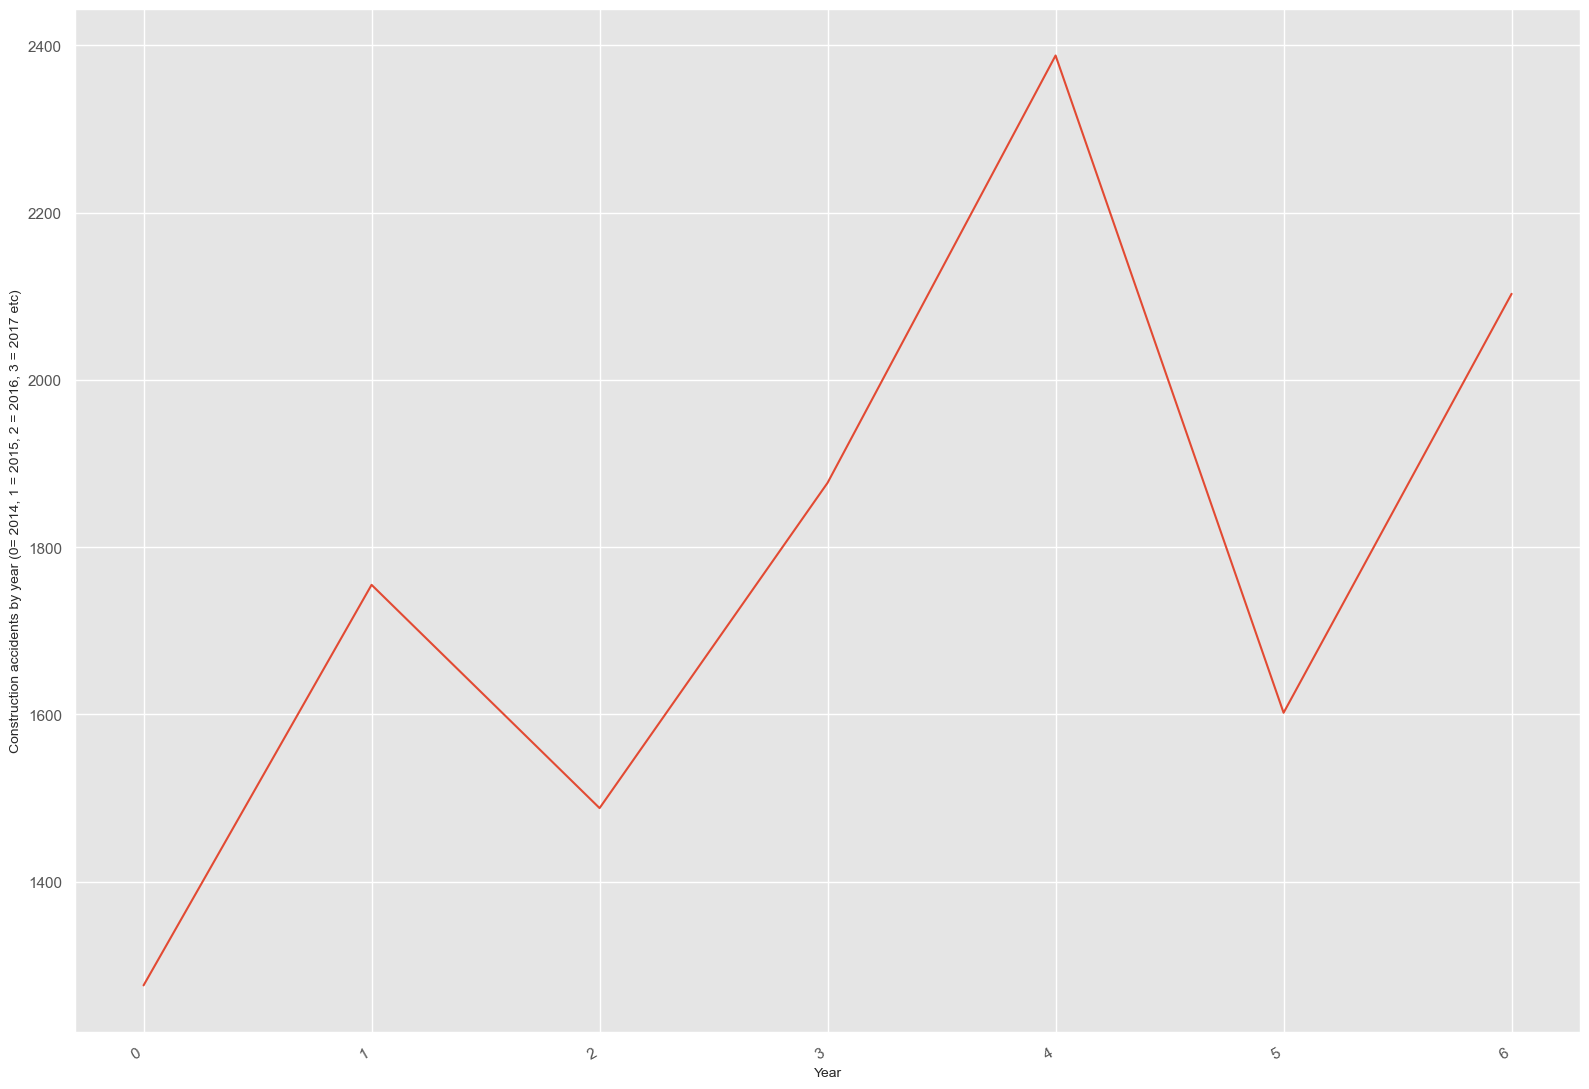

In [8]:
fig, ax = plt.subplots(figsize=(16, 11))

ax.plot(data['Ireland'])
ax.set_xlabel('Year')
ax.set_ylabel('Construction accidents by year (0= 2014, 1 = 2015, 2 = 2016, 3 = 2017 etc)')

fig.autofmt_xdate()
plt.tight_layout()

In [9]:
#  data = data.interpolate()  No missing data

In [10]:
# Predict the next step using the last observation
df = data.copy()

df['y'] = df['Ireland'].shift(-1)
df

,Year,Ireland,y
0,2014-01-01,1276.0,1755.0
1,2015-01-01,1755.0,1488.0
2,2016-01-01,1488.0,1877.0
3,2017-01-01,1877.0,2388.0
4,2018-01-01,2388.0,1602.0
5,2019-01-01,1602.0,2103.0
6,2020-01-01,2103.0,NaN


In [11]:
train = df[:-3]
test = df[-3:]


In [12]:
#Baseline model: repeat the last observation
test = test.copy()
test['baseline_pred'] = test['Ireland']

test = test.drop(test.tail(1).index) # Drop last row

test

,Year,Ireland,y,baseline_pred
4,2018-01-01,2388.0,1602.0,2388.0
5,2019-01-01,1602.0,2103.0,1602.0


In [13]:
# Apply a Decision Tree
from sklearn.tree import DecisionTreeRegressor

X_train = train['Ireland'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['Ireland'].values.reshape(-1,1)

# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_reg.fit(X=X_train, y=y_train)

# Make predictions
dt_pred = dt_reg.predict(X_test)

# Assign predictions to a new column in test
test['dt_pred'] = dt_pred
test

,Year,Ireland,y,baseline_pred,dt_pred
4,2018-01-01,2388.0,1602.0,2388.0,2388.0
5,2019-01-01,1602.0,2103.0,1602.0,1877.0


In [14]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [15]:
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])

print(f'Baseline: {baseline_mape}%')
print(f'Decision Tree: {dt_mape}%')

Baseline: 36.44%
Decision Tree: 29.91%


In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y=y_train.ravel())

gbr_pred = gbr.predict(X_test)

test['gbr_pred'] = gbr_pred

test

,Year,Ireland,y,baseline_pred,dt_pred,gbr_pred
4,2018-01-01,2388.0,1602.0,2388.0,2388.0,2387.986427
5,2019-01-01,1602.0,2103.0,1602.0,1877.0,1877.000000


In [17]:
gbr_mape = mape(test['Ireland'], test['gbr_pred'])

print(f'Gradient Boosting Regressor: {gbr_mape}%')

Gradient Boosting Regressor: 8.58%


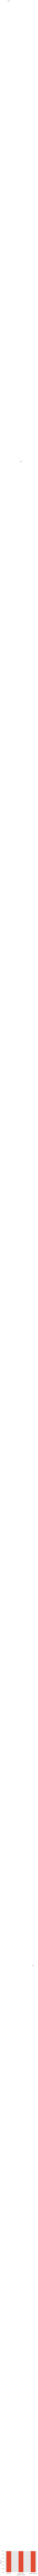

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))


x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

In [19]:
#Predict the next step with a window as input
data

,Year,Ireland
0,2014-01-01,1276.0
1,2015-01-01,1755.0
2,2016-01-01,1488.0
3,2017-01-01,1877.0
4,2018-01-01,2388.0
5,2019-01-01,1602.0
6,2020-01-01,2103.0


In [20]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['Ireland'].shift(-i)
        i = i + 1
        
    if i == window_length:
        df['y'] = df['Ireland'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

In [21]:
new_df = window_input(5, data)
new_df

,Year,Ireland,x_1,x_2,x_3,x_4,y
0,2014-01-01,1276.0,1755.0,1488.0,1877.0,2388.0,1602.0
1,2015-01-01,1755.0,1488.0,1877.0,2388.0,1602.0,2103.0


In [22]:
from sklearn.model_selection import train_test_split

X = new_df[['Ireland', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [23]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

In [24]:
# Apply a decision tree
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(X_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(X_test)

In [25]:
# Apply gradient boosting
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

In [26]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)

print(f'Baseline MAPE: {baseline_mape}%')
print(f'Decision Tree MAPE: {dt_5_mape}%')
print(f'Gradient Boosting MAPE: {gbr_5_mape}%')

Baseline MAPE: 13.36%
Decision Tree MAPE: 23.82%
Gradient Boosting MAPE: 23.82%


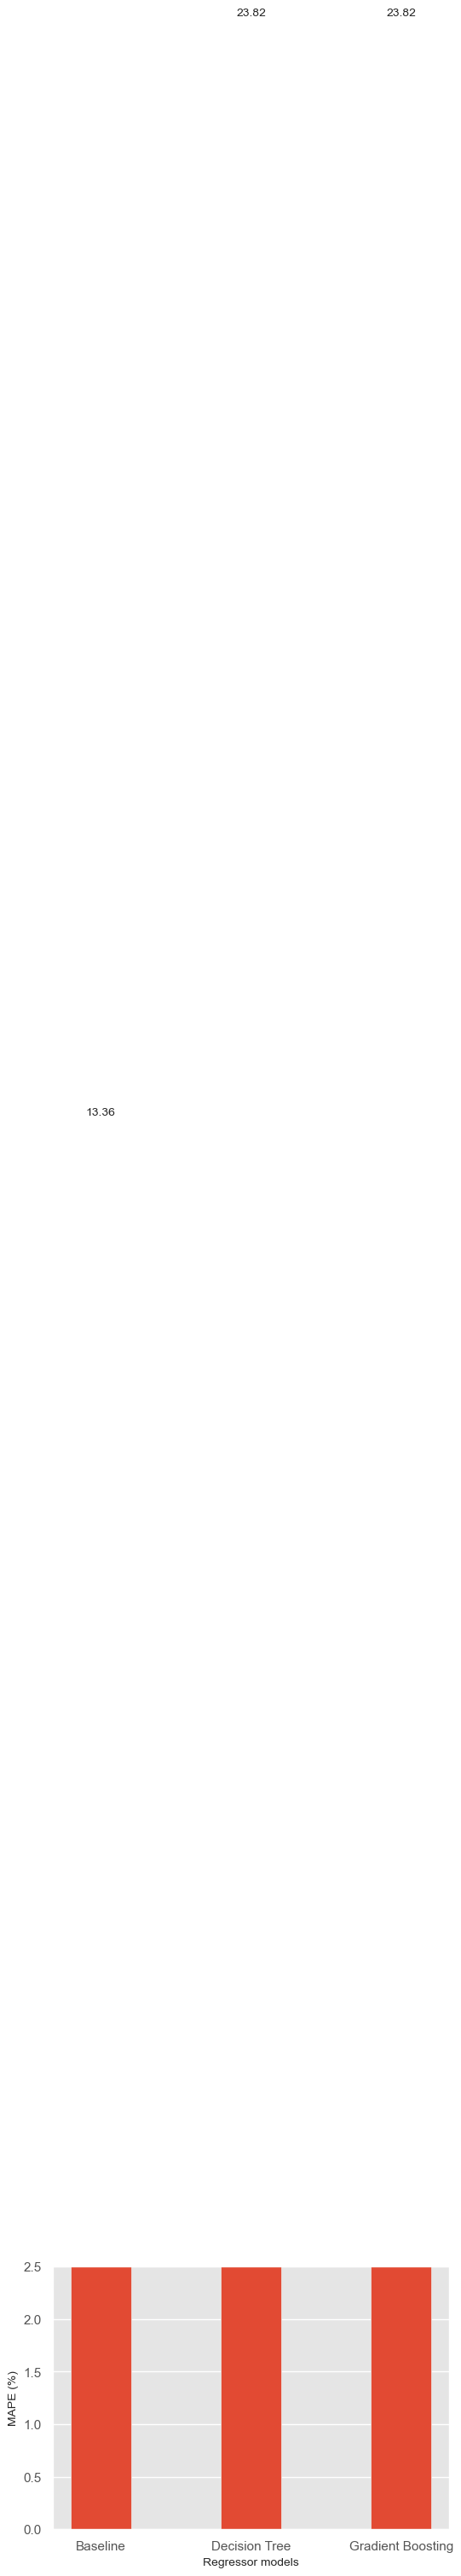

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

In [28]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['Ireland'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['Ireland'].shift(-output_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

In [29]:
seq_df = window_input_output(1, 1, data)

In [30]:
seq_df

,Year,Ireland,y_0
0,2014-01-01,1276.0,1755.0
1,2015-01-01,1755.0,1488.0
2,2016-01-01,1488.0,1877.0
3,2017-01-01,1877.0,2388.0
4,2018-01-01,2388.0,1602.0
5,2019-01-01,1602.0,2103.0


In [31]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'Ireland')

y_cols = [col for col in seq_df.columns if col.startswith('y')]

In [32]:
X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

In [33]:
# Apply a decision tree
dt_seq = DecisionTreeRegressor(random_state=42)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)

In [34]:
# Apply gradient boosting
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

In [35]:
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_dt_seq

22.48

In [36]:
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq

22.48

In [37]:
mape_baseline = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
mape_baseline

32.09

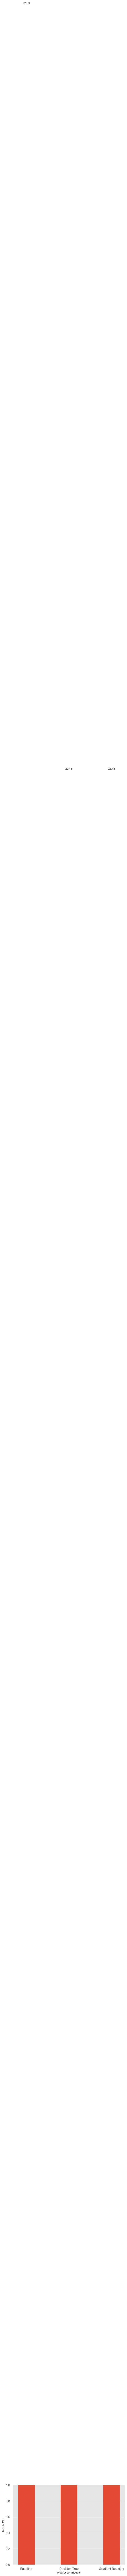

In [38]:
fig, ax = plt.subplots(figsize=(7, 5))

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [mape_baseline, mape_dt_seq, mape_gbr_seq]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

In [39]:
### Finished.  The no. of samples was very low so the predictions were somewhat inaccurate.  The decision tree and gradient boost algorithms performed the same as the baseline model.